In [ ]:

import os
import re
import email
import pandas as pd
import requests
from email import policy
from email.parser import BytesParser
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
def parse_email(file_path):
    with open(file_path, 'rb') as f:
        msg = BytesParser(policy=policy.default).parse(f)
    headers = dict(msg.items())
    body = msg.get_body(preferencelist=('plain', 'html'))
    return {
        "subject": headers.get("Subject", ""),
        "from": headers.get("From", ""),
        "to": headers.get("To", ""),
        "received": headers.get("Received", ""),
        "date": headers.get("Date", ""),
        "body": body.get_content() if body else ""
    }

def clean_email_body(raw_html):
    if not raw_html:
        return ""
    soup = BeautifulSoup(raw_html, "html.parser")
    return soup.get_text(separator=" ", strip=True)

def extract_info_from_received(received_header):
    ip_match = re.search(r'\[?(\d{1,3}(?:\.\d{1,3}){3})\]?', received_header)
    ip = ip_match.group(1) if ip_match else None

    domain_match = re.search(r'from\s+([\w\.-]+)', received_header, re.IGNORECASE)
    domain = domain_match.group(1) if domain_match else None

    return ip, domain

def load_emails_from_folder(folder_path, label):
    emails = []
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        try:
            parsed = parse_email(file_path)
            ip, domain = extract_info_from_received(parsed["received"])
            emails.append({
                "from": parsed["from"],
                "subject": parsed["subject"],
                "date": parsed["date"],
                "text": clean_email_body(parsed["body"]),
                "ip": ip,
                "domain": domain,
                "label": label
            })
        except Exception as e:
            continue
    return emails

def enrich_ip_metadata(ip):
    if not ip or ip.startswith("192.") or ip.startswith("10.") or ip.startswith("127."):
        return {"country": None, "org": None}
    try:
        r = requests.get(f"http://ip-api.com/json/{ip}", timeout=5)
        if r.status_code == 200:
            data = r.json()
            return {
                "country": data.get("country"),
                "org": data.get("org")
            }
    except:
        pass
    return {"country": None, "org": None}


In [ ]:
ham_folder = "easy_ham"
spam_folder = "spam"
spam2_folder = "spam_2"

ham_emails = load_emails_from_folder(ham_folder, 0)
spam_emails = load_emails_from_folder(spam_folder, 1)
spam2_emails = load_emails_from_folder(spam2_folder, 1)

all_emails = pd.DataFrame(ham_emails + spam_emails + spam2_emails)
all_emails = all_emails[all_emails['text'].notnull()].sample(frac=1).reset_index(drop=True)
print(f"Total emails loaded: {len(all_emails)}")


Total emails loaded: 4015


In [17]:
# Find top 50 most common spam IPs
top_ips = (
    all_emails[all_emails['label'] == 1]
    .dropna(subset=["ip"])
    .groupby('ip')
    .size()
    .sort_values(ascending=False)
    .head(50)
    .index
)

# Filter all spam emails with these IPs
sampled = all_emails[
    (all_emails['label'] == 1) & (all_emails['ip'].isin(top_ips))
].copy()

print(f"Total spam emails from top 50 IPs: {len(sampled)}")


Total spam emails from top 50 IPs: 153


In [18]:
# Enrich IP metadata (lookup only unique IPs)
unique_sampled_ips = sampled['ip'].dropna().unique()
ip_metadata = {ip: enrich_ip_metadata(ip) for ip in unique_sampled_ips}
sampled['country'] = sampled['ip'].map(lambda ip: ip_metadata.get(ip, {}).get('country', None))
sampled['org'] = sampled['ip'].map(lambda ip: ip_metadata.get(ip, {}).get('org', None))
sampled['text_preview'] = sampled['text'].str.replace('\n', ' ').str.replace('\r', ' ')


In [19]:
# CSV
csv_path = "top_50_spam_ips.csv"
sampled.to_csv(csv_path, index=False)

# TXT
txt_path = "top_50_spam_ips.txt"
with open(txt_path, "w", encoding="utf-8") as f:
    for _, row in sampled.iterrows():
        f.write(f"IP: {row['ip']}\n")
        f.write(f"Domain: {row['domain']}\n")
        f.write(f"Country: {row['country']}\n")
        f.write(f"Org: {row['org']}\n")
        f.write(f"From: {row['from']}\n")
        f.write(f"Subject: {row['subject']}\n")
        f.write(f"Date: {row['date']}\n")
        f.write(f"Label: {'Spam' if row['label'] == 1 else 'Ham'}\n")
        f.write(f"Preview: {row['text_preview']}\n")
        f.write("-" * 60 + "\n")

print(f"✅ Files saved:\nCSV: {csv_path}\nTXT: {txt_path}")


✅ Files saved:
CSV: top_50_spam_ips.csv
TXT: top_50_spam_ips.txt


In [20]:
ml_data = all_emails[['from', 'subject', 'text', 'label']]
ml_csv_path = "emails_for_ml.csv"
ml_data.to_csv(ml_csv_path, index=False)
print(f"✅ ML training data saved to: {ml_csv_path}")


✅ ML training data saved to: emails_for_ml.csv


In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV (change filename if needed)
df = pd.read_csv("top_50_spam_ips.csv")

# Count by country (ignoring missing/None)
country_counts = df['country'].value_counts(dropna=True)
print(country_counts)


country
United States      57
China              17
Australia           7
Mexico              4
Brazil              4
South Korea         4
Sweden              3
Philippines         3
Spain               3
Taiwan              3
United Kingdom      3
Argentina           3
Panama              2
The Netherlands     2
Singapore           2
Japan               2
Türkiye             2
Name: count, dtype: int64


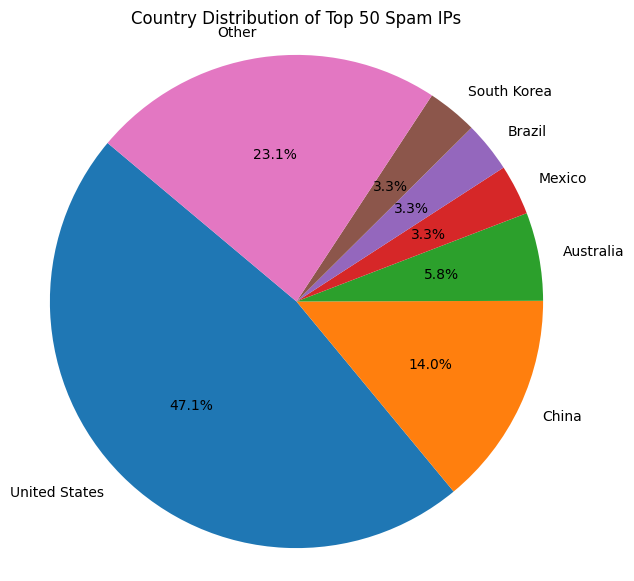

In [22]:
top_countries = country_counts.head(6)
other = country_counts[6:].sum()
labels = list(top_countries.index) + ['Other']
sizes = list(top_countries.values) + [other]

plt.figure(figsize=(7,7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title("Country Distribution of Top 50 Spam IPs")
plt.axis('equal')
plt.show()


In [23]:
import pandas as pd

# Load the CSV (change filename if needed)
df = pd.read_csv("top_50_spam_ips.csv")

# Count by domain (ignoring missing/None)
domain_counts = df['domain'].value_counts(dropna=True)
print(domain_counts.head(10))  # Show top 10 domains

domain
mx06.hotmail.com           7
unknown                    7
rovweb003                  4
localhost                  4
163.com                    4
rovweb002                  4
yahoo.com                  3
smtp0412.mail.yahoo.com    3
Mailer                     3
waynemain                  3
Name: count, dtype: int64


📊 Spam Type Distribution:
spam_type
General Spam     61
Phishing         58
Lottery Scam     25
Advertising       6
Banking Fraud     3
Name: count, dtype: int64


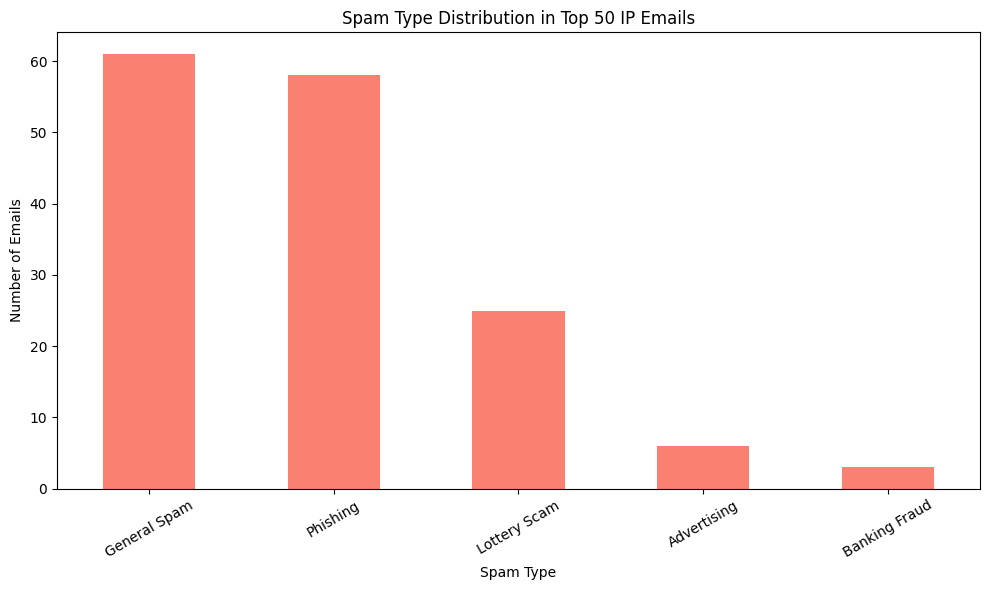

In [ ]:
# Categorize spam emails into specific types

def categorize_spam(text):
    text = text.lower()

    # Category: Email Spoofing
    if any(keyword in text for keyword in [
        "impersonating", "pretending to be", "fake sender", "spoofed email", 
        "this is not from", "unauthorized email", "suspicious sender"
    ]):
        return "Email Spoofing"

    # Category: Antivirus Warnings
    elif any(keyword in text for keyword in [
        "virus detected", "your pc is infected", "security threat", 
        "antivirus expired", "system at risk", "trojan warning"
    ]):
        return "Antivirus Warnings"

    # Category: Commercial Advertisements
    elif any(keyword in text for keyword in [
        "buy now", "sale", "discount", "limited time offer", 
        "promotion", "subscribe now", "exclusive deal", "order today"
    ]):
        return "Commercial Advertisements"

    # Category: Phishing & Account Alerts
    elif any(keyword in text for keyword in [
        "account suspended", "login now", "verify account", "click here", 
        "update information", "reset password", "unusual activity"
    ]):
        return "Phishing & Account Alerts"

    # Default category
    else:
        return "General Spam"

# Apply the updated categorization
sampled["spam_type"] = sampled["text"].apply(categorize_spam)

# Show distribution
spam_type_counts = sampled["spam_type"].value_counts()
print("📊 Spam Type Distribution:")
print(spam_type_counts)

# Bar chart
plt.figure(figsize=(10,6))
spam_type_counts.plot(kind="bar", color="mediumseagreen")
plt.title("Categorized Spam Types in Top 50 IP Emails")
plt.xlabel("Spam Type")
plt.ylabel("Number of Emails")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()
